#**Housing Proces Prediction**

@ Kaggle competition by Oliver Den, Toronto

The work is divided into 2 parts, the first being an EDA and the second – a prediction. 

The EDA stage will include performing data cleansing and wrangling for regularization.


In [44]:
# work with google drive 

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# load packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm

np.random.seed(12345)

# EDA

The EDA stage shall include:

- Extracting important variables and leaving behind useless variables
- Identifying outliers, missing values, or human error
- Understanding the relationship(s), or lack of, between variables
- Ultimately, maximizing your insights of a dataset and minimizing potential error that may occur later in the process

(based on: https://towardsdatascience.com/an-extensive-guide-to-exploratory-data-analysis-ddd99a03199e)

In [46]:
# load clean datasets 

train_set = pd.read_csv('/content/drive/MyDrive/Kaggle/house-prices-advanced-regression-techniques/train.csv')
test_set = pd.read_csv('/content/drive/MyDrive/Kaggle/house-prices-advanced-regression-techniques/test.csv')

Our analysis shows the absence of duplicated values in both train & test sets.

Further, we will work with the log of SalePrice, therefore we will add a SalePrice_log column to the train_set and test_set from the start.

In [47]:
# show a sum of duplicates in the train set

print(train_set.duplicated(keep=False).sum())
print(test_set.duplicated(keep=False).sum())

0
0


We perform steps to compare the columns in both sets to ensure that none of the columns is omitted from the analysis.

In [48]:
# create lists of columns for both sets

train_set_columns = list(train_set)
test_set_columns = list(test_set)

In [49]:
# compare the two lists and find out the difference:

columns_missing_in_test_set = []

for i in train_set_columns:
    if i not in test_set_columns:
       columns_missing_in_test_set.append(i)

columns_missing_in_train_set = []

for i in test_set_columns:
    if i not in train_set_columns:
       columns_missing_in_train_set.append(i)

After running the search, we realize that in the test set, there is no 'SalePrice' column which is our target column.

In the train set, there are no missing columns.

### Explore Missing Values

The next step includes exploring the content of both sets.

IDs of values in the train set are in the range of 1 to 1460, and in the test set - from 1461 to 2919.

We run .info() for more insight in the missing values.

In [50]:
# check the info - train set 

train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [51]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

For further processing, we will create a ‘schema’ from the ‘larger’ train set to fix the order of columns in the joined set, which we create from both train & test sets. 

In [52]:
# use the order of columns from train_set to create a schema to ensure that the order of columns in two sets is identical

schema_columns = train_set_columns

# concatinating using the schema 

concat_set = pd.concat([train_set.reindex(schema_columns, axis=1), 
                test_set.reindex(schema_columns, axis=1)], sort=False, ignore_index=True)

# create a merged set

train_test = concat_set

In [53]:
# log-transform numerical variables ex ['Id', 'SalePrice'] because they are either unimportant or already transformed

numerical_variables = train_test.drop(columns = ['Id', 'SalePrice']).select_dtypes(include=np.number).columns.tolist()

In [54]:
# remove Id and SalePrice because we don't need them for data cleansing 

train_test = train_test.drop(columns = ['Id', 'SalePrice'])

In [55]:
for i in numerical_variables:
  train_test[i] = np.log10(train_test[i]+0.000001) # adding a constant to avoid problems with zero values 
  #train_test[i] = train_test[i].apply(lambda x: np.nan if x == (-np.inf) else x)

In [56]:
# create a target - SalePrice_log

train_set['SalePrice_log'] = np.log10(train_set['SalePrice'])

The following step involves plotting the missing values. 

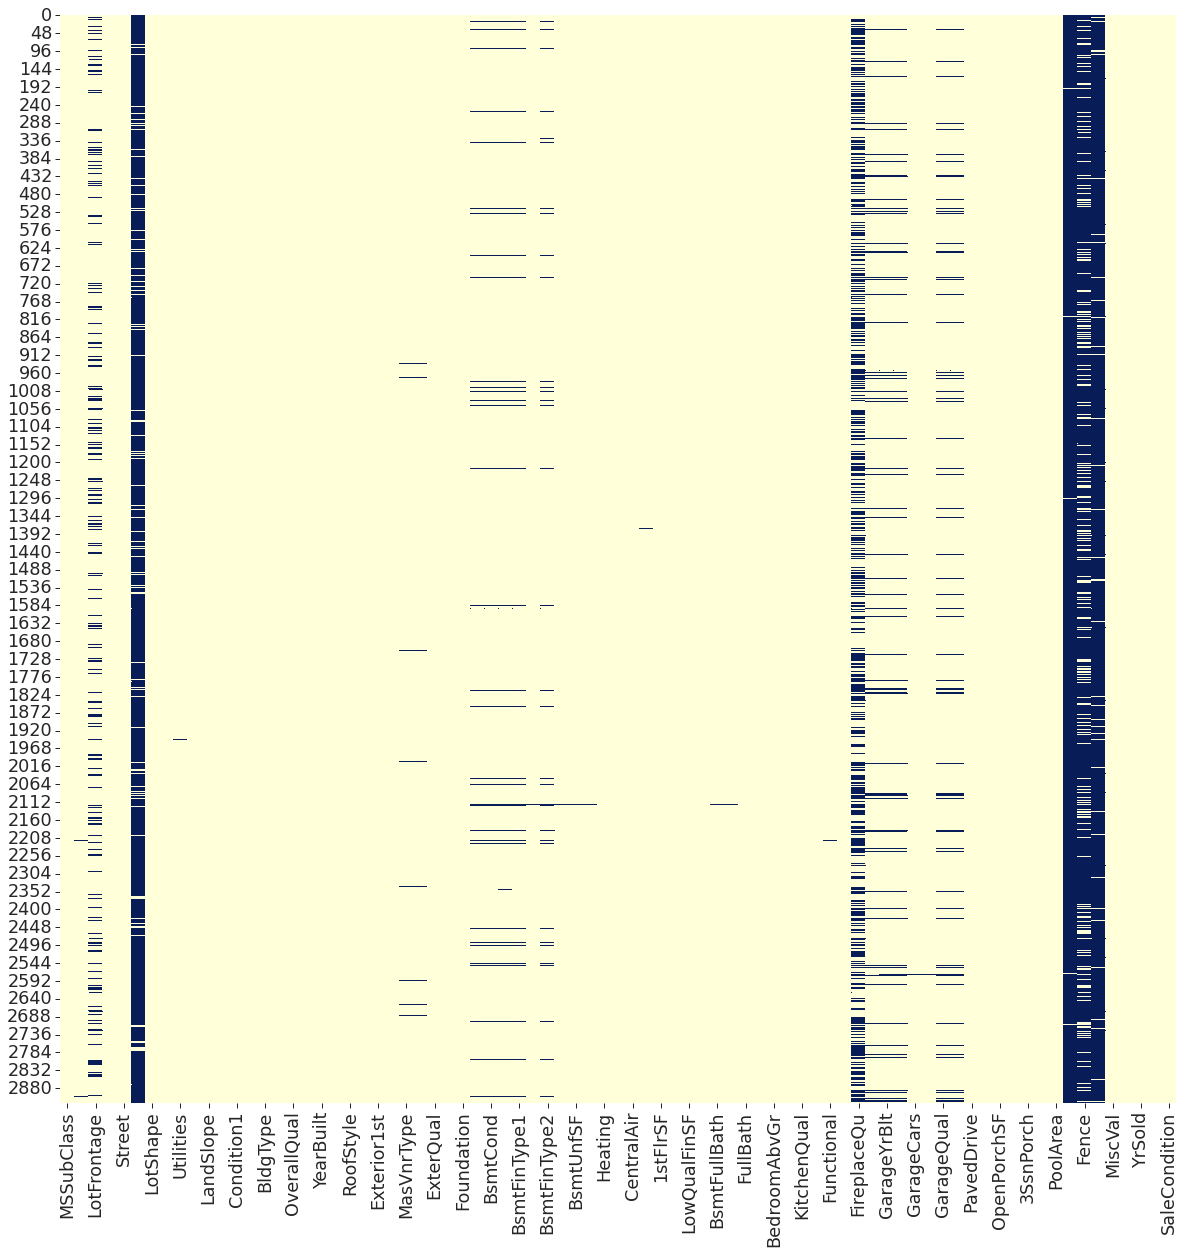

In [57]:
# plot the missing data in the concatinated set

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(train_test.isnull(), cbar=False, cmap = 'YlGnBu')
plt.show() 

**Observations:** 
- the plot show multiple rows containing zero values in both train and test data;
- visually, multiple columns miss more than 50% of values.

### NaN-Checker

Further, we implement a function to check for missing values and list the columns with those missing values, including the count of missing values. 

In [58]:
# NaN checker - create a function to check missing values

def nan_checker(data_set): 

    summary = {}
    # are there any nan values?
    any_nans = data_set.isna().any().any()
    
    summary['NaNs Exist'] = any_nans
    
    # how many?
    n_nans = data_set.isna().sum().sum()
    summary['NaN Count'] = n_nans
    
    # which variables do they come from
    nan_column_series = data_set.isna().sum()
    nan_column_names = list(nan_column_series[nan_column_series > 0].index)
    
    summary['NaN Containing Columns'] = nan_column_names
    
    
    # any variables with more than 50% of data missing?
    nan_column_percent = 100 * nan_column_series/data_set.shape[0]
    nan_columns_with_more_than_50_pct = list(nan_column_percent[nan_column_percent > 50].index)
    
    summary['NaNs More Than 50%'] = nan_columns_with_more_than_50_pct
    
    #summary can be all the info about nans
    return(summary)

In [59]:
# show NaNs in the train_test

print(nan_checker(train_test)) # same picture as revealed by the heatmap above

{'NaNs Exist': True, 'NaN Count': 13965, 'NaN Containing Columns': ['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType'], 'NaNs More Than 50%': ['Alley', 'PoolQC', 'Fence', 'MiscFeature']}


In [60]:
# provide counts of the columns with missing values

missing_count = len(list(train_test.isna().sum()[train_test.isna().sum() > 0].index))

# count of missing columns

print(missing_count) # 34 columns with missing values 


34


**Observation**:
- 4 columns contain > 50% of missing values;
- NaN Count: 15424;
- 35 columns contain missing values in total;
- we aren't worried about the missing 'SalePrice' because it is the target variable.

Next, we would like to create a list of missing values in the combined set to further create a register of missing values that would allow us to successfully eliminate them.

In [61]:
# create a list of missing values 

list_missing = list(train_test.isnull().sum()[train_test.isnull().sum() != 0].index)

### Missing Values Registers

In [62]:
# show the data types of the columns with missing values 

def missing_values_register():

  # create a list of columns with missing values 

    list_missing = list(train_test.isnull().sum()[train_test.isnull().sum() != 0].index)

# create a dictionary containing the names and the description of columns with missing values 

    dict_descr = {
              'name_column': [
                              "SalePrice",
                              "MSSubClass",
                              "MSZoning",
                              "LotFrontage",
                              "LotArea",
                              "Street",
                              "Alley",
                              "LotShape",
                              "LandContour",
                              "Utilities",
                              "LotConfig",
                              "LandSlope",
                              "Neighborhood",
                              "Condition1",
                              "Condition2",
                              "BldgType",
                              "HouseStyle",
                              "OverallQual",
                              "OverallCond",
                              "YearBuilt",
                              "YearRemodAdd",
                              "RoofStyle",
                              "RoofMatl",
                              "Exterior1st",
                              "Exterior2nd",
                              "MasVnrType",
                              "MasVnrArea",
                              "ExterQual",
                              "ExterCond",
                              "Foundation",
                              "BsmtQual",
                              "BsmtCond",
                              "BsmtExposure",
                              "BsmtFinType1",
                              "BsmtFinSF1",
                              "BsmtFinType2",
                              "BsmtFinSF2",
                              "BsmtUnfSF",
                              "TotalBsmtSF",
                              "Heating",
                              "HeatingQC",
                              "CentralAir",
                              "Electrical",
                              "1stFlrSF",
                              "2ndFlrSF",
                              "LowQualFinSF",
                              "GrLivArea",
                              "BsmtFullBath",
                              "BsmtHalfBath",
                              "FullBath",
                              "HalfBath",
                              "Bedroom",
                              "Kitchen",
                              "KitchenQual",
                              "TotRmsAbvGrd",
                              "Functional",
                              "Fireplaces",
                              "FireplaceQu",
                              "GarageType",
                              "GarageYrBlt",
                              "GarageFinish",
                              "GarageCars",
                              "GarageArea",
                              "GarageQual",
                              "GarageCond",
                              "PavedDrive",
                              "WoodDeckSF",
                              "OpenPorchSF",
                              "EnclosedPorch",
                              "3SsnPorch",
                              "ScreenPorch",
                              "PoolArea",
                              "PoolQC",
                              "Fence",
                              "MiscFeature",
                              "MiscVal",
                              "MoSold",
                              "YrSold",
                              "SaleType",
                              "SaleCondition"],
              'description': [
                              "The property's sale price in dollars, this is the target variable that you're trying to predict",
                              "The building class",
                              "The general zoning classification",
                              "Linear feet of street connected to property",
                              "Lot size in square feet",
                              "Type of road access",
                              "Type of alley access",
                              "General shape of property",
                              "Flatness of the property",
                              "Type of utilities available",
                              "Lot configuration",
                              "Slope of property",
                              "Physical locations within Ames city limits",
                              "Proximity to main road or railroad",
                              "Proximity to main road or railroad (if a second is present)",
                              "Type of dwelling",
                              "Style of dwelling",
                              "Overall material and finish quality",
                              "Overall condition rating",
                              "Original construction date",
                              "Remodel date",
                              "Type of roof",
                              "Roof material",
                              "Exterior covering on house",
                              "Exterior covering on house (if more than one material)",
                              "Masonry veneer type",
                              "Masonry veneer area in square feet",
                              "Exterior material quality",
                              "Present condition of the material on the exterior",
                              "Type of foundation",
                              "Height of the basement",
                              "General condition of the basement",
                              "Walkout or garden level basement walls",
                              "Quality of basement finished area",
                              "Type 1 finished square feet",
                              "Quality of second finished area (if present)",
                              "Type 2 finished square feet",
                              "Unfinished square feet of basement area",
                              "Total square feet of basement area",
                              "Type of heating",
                              "Heating quality and condition",
                              "Central air conditioning",
                              "Electrical system",
                              "First Floor square feet",
                              "Second floor square feet",
                              "Low quality finished square feet (all floors)",
                              "Above grade (ground) living area square feet",
                              "Basement full bathrooms",
                              "Basement half bathrooms",
                              "Full bathrooms above grade",
                              "Half baths above grade",
                              "Number of bedrooms above basement level",
                              "Number of kitchens",
                              "Kitchen quality",
                              "Total rooms above grade (does not include bathrooms)",
                              "Home functionality rating",
                              "Number of fireplaces",
                              "Fireplace quality",
                              "Garage location",
                              "Year garage was built",
                              "Interior finish of the garage",
                              "Size of garage in car capacity",
                              "Size of garage in square feet",
                              "Garage quality",
                              "Garage condition",
                              "Paved driveway",
                              "Wood deck area in square feet",
                              "Open porch area in square feet",
                              "Enclosed porch area in square feet",
                              "Three season porch area in square feet",
                              "Screen porch area in square feet",
                              "Pool area in square feet",
                              "Pool quality",
                              "Fence quality",
                              "Miscellaneous feature not covered in other categories",
                              "$Value of miscellaneous feature",
                              "Month Sold",
                              "Year Sold",
                              "Type of sale",
                              "Condition of sale"]}
    name_column = []
    data_type = []
    mis_vals_count = []

    for column in list_missing:
      if train_test[column].isnull().sum() > 0:
        name_column.append(column)
        data_type.append(train_test[column].dtype) 
        mis_vals_count.append(train_test[column].isnull().sum())

    null_dtypes_val_train_test = pd.DataFrame(data=list(zip(name_column, data_type, mis_vals_count)), columns=['name_column', 'data_type', 'mis_vals_count'])

    from operator import index
    dict_df = pd.DataFrame.from_dict(dict_descr)
    null_dtypes_val_train_test = null_dtypes_val_train_test.merge(dict_df, on = 'name_column', how = 'left')
    return(null_dtypes_val_train_test)



In [63]:
missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,486,Linear feet of street connected to property
2,Alley,object,2721,Type of alley access
3,Utilities,object,2,Type of utilities available
4,Exterior1st,object,1,Exterior covering on house
5,Exterior2nd,object,1,Exterior covering on house (if more than one m...
6,MasVnrType,object,24,Masonry veneer type
7,MasVnrArea,float64,23,Masonry veneer area in square feet
8,BsmtQual,object,81,Height of the basement
9,BsmtCond,object,82,General condition of the basement


### Dealing With and Exploring Missing Values 

**Steps**

I. Understand the relationships between a variable in question and decide on the principles on how to fill the missing values in it.
II. Explore the variable in question, identify outliers and deal with them.

**Columns with missing values**

0.        SalePrice - not to be filled in, because it is the target variable.
1.         MSZoning
2.      LotFrontage
3.            Alley
4.        Utilities
5.      Exterior1st
6.      Exterior2nd
7.       MasVnrType
8.       MasVnrArea
9.         BsmtQual
10.        BsmtCond
11.    BsmtExposure
12.    BsmtFinType1
13.      BsmtFinSF1
14.    BsmtFinType2
15.      BsmtFinSF2
16.       BsmtUnfSF
17.     TotalBsmtSF
18.      Electrical
19.    BsmtFullBath
20.    BsmtHalfBath
21.         Bedroom
22.         Kitchen
23.     KitchenQual
24.      Functional
25.     FireplaceQu
26.      GarageType
27.     GarageYrBlt
28.    GarageFinish
29.      GarageCars
30.      GarageArea
31.      GarageQual
32.      GarageCond
33.          PoolQC
34.           Fence
35.     MiscFeature
36.        SaleType




In [64]:
print(set(train_test[train_test['LotFrontage'].isnull()]['MSZoning'])) # zoning classification
print(set(train_test[train_test['LotFrontage'].isnull()]['MSSubClass'])) # types of dwellings 
print(set(train_test[train_test['LotFrontage'].isnull()]['LotConfig'])) # lot configuration
print(set(train_test[train_test['LotFrontage'].isnull()]['BldgType'])) # type of dwelling
print(set(train_test[train_test['LotFrontage'].isnull()]['Street'])) # type of road 
print(set(train_test[train_test['LotFrontage'].isnull()]['Alley'])) # type of alley

{nan, 'RH', 'FV', 'RM', 'C (all)', 'RL'}
{1.778151257621885, 1.6989700130219083, 1.9030899924206246, 1.9294189308236396, 1.3010300173787048, 2.0791812496667457, 2.2041199853702653, 1.4771212691961448, 1.875061269182293, 1.954242514264819, 2.2787536032385893, 1.6020600021853242, 2.2552725075160533, 2.176091261950978, 1.8450980462184636}
{'Corner', 'FR2', 'Inside', 'FR3', 'CulDSac'}
{'Duplex', '1Fam', '2fmCon', 'Twnhs', 'TwnhsE'}
{'Pave', 'Grvl'}
{nan, 'Pave', 'Grvl'}


**Observation:**
The missing values in LotFrontage are present across most of types of dwellings, but exist only in RM - Residential Medium Density, RL - Residential Low Density, FV - Floating Village Residential and C - Commercial. 
The absence of linear feet of street corresponds to lots with frontages on 2 and 3 sides and 



**SalePrice**

We will examine the distribution of SalePrice in the train set, as the data for test set is not available.

Text(180921.19589041095, 125, 'Mean')

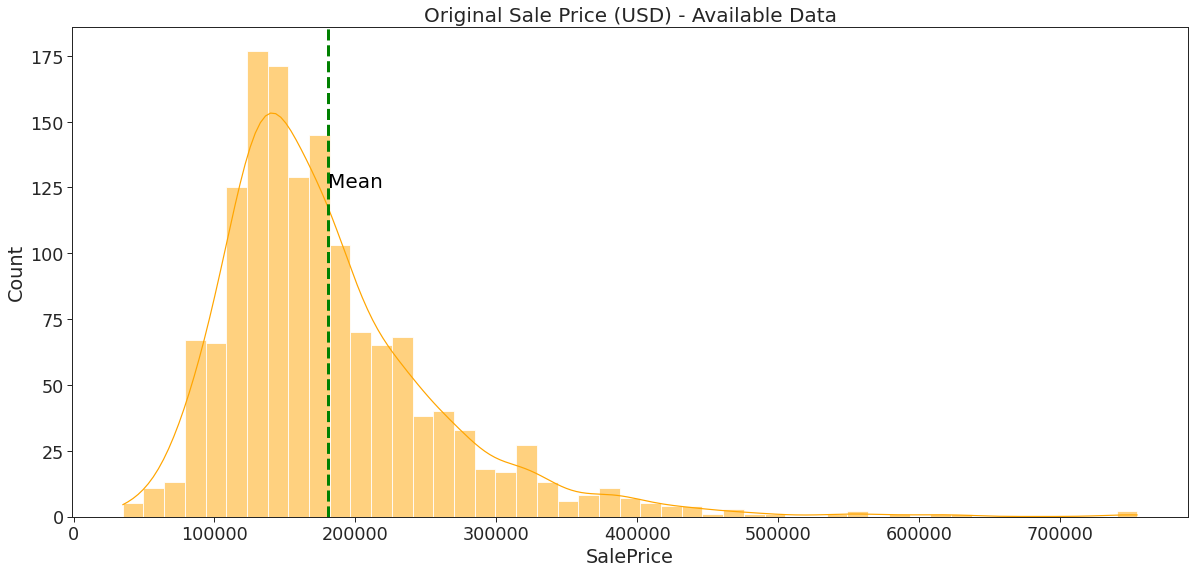

In [65]:
# plot the SalePrice 

plt.figure(figsize=(20,9)) 
sns.set_style("ticks")
sns.set_context("paper", font_scale=2)


salepriceplot = sns.histplot(train_set['SalePrice'],color="orange",kde=True).set_title('Original Sale Price (USD) - Available Data', fontdict = { 'fontsize': 20}) 
plt.axvline(x=train_set['SalePrice'].mean(), color='g', linestyle='--', linewidth=3)
plt.text(train_set['SalePrice'].mean(), 125, "Mean", horizontalalignment='left', size=20, color='black')

# inspired by Oh Seok Kim on Kaggle



Clearly, the SalePrice is not normally distributed and is right-skewed. We can use a box-plot to confirm our initial supposition.



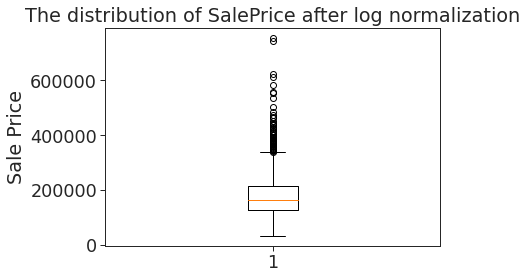

In [66]:
plt.figure()
plt.boxplot(train_set.SalePrice)
plt.title('The distribution of SalePrice after log normalization')
plt.ylabel('Sale Price')
plt.show()

We observe a large number of outliers in the price point above the maximum. We will use the boxplot definition to count such outliers (Q3+(1.5 . IQR).

In [67]:
# demonstrate count outliers 

from matplotlib.cbook import boxplot_stats  
boxplot_stats(train_set.SalePrice).pop(0)['fliers']
len(boxplot_stats(train_set.SalePrice).pop(0)['fliers'])

61

The above identifies 61 houses that are overly expensive. 

We will use log transformation to bring the Sale Price closer to normal distribution. Then, we will analyse the outliers again and drop those entirely.

Text(5.221978956475622, 125, 'Mean')

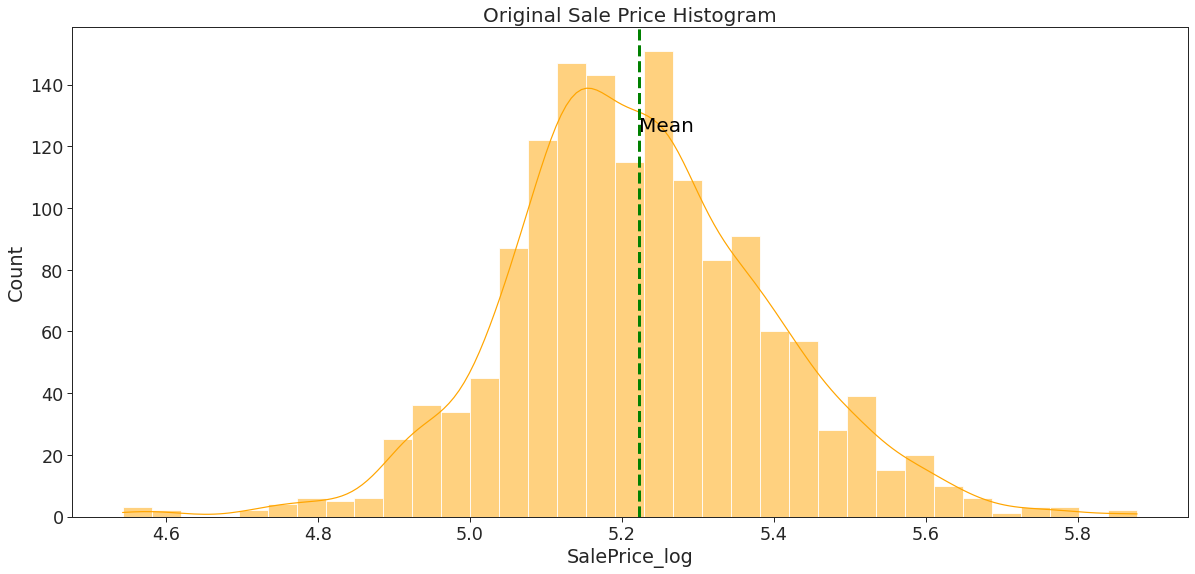

In [68]:
# check the distribution

plt.figure(figsize=(20,9)) 
sns.set_style("ticks")
sns.set_context("paper", font_scale=2)


salepriceplot = sns.histplot(train_set['SalePrice_log'] ,color="orange",kde=True).set_title('Original Sale Price Histogram', fontdict = { 'fontsize': 20}) 
plt.axvline(x=train_set['SalePrice_log'] .mean(), color='g', linestyle='--', linewidth=3)
plt.text(train_set['SalePrice_log'] .mean(), 125, "Mean", horizontalalignment='left', size=20, color='black')

At this moment the SalePrice distribution seems normal. Let's create a boxplot of the it to see if there are any significant outliers.

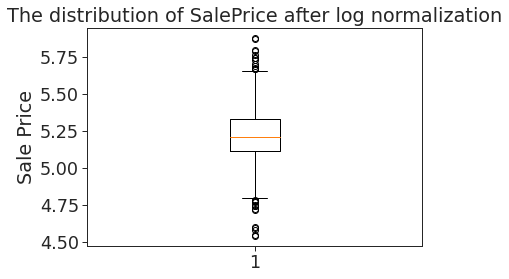

In [69]:
# create a box plot to identify outliers 

plt.figure()
plt.boxplot(train_set.SalePrice_log)
plt.title('The distribution of SalePrice after log normalization')
plt.ylabel('Sale Price')
plt.show()

In [70]:
#identify outliers as the values that are 3 st. dev. aaway from the mean

from matplotlib.cbook import boxplot_stats  

print(len(boxplot_stats(train_set.SalePrice_log).pop(0)['fliers']))
outliers = (boxplot_stats(train_set.SalePrice_log).pop(0)['fliers']).tolist()
outliers = set(outliers)
outliers = list(outliers) 
print(len(outliers))

28
25


In [71]:
outliers

[4.54282542695918,
 5.744292983122676,
 4.778151250383644,
 4.6020599913279625,
 4.785329835010767,
 4.594392550375427,
 4.740362689494244,
 4.7160033436347994,
 4.748133736802754,
 4.547910016864493,
 5.70056267830869,
 4.578639209968072,
 4.720159303405957,
 4.767155866082181,
 5.730782275666389,
 5.685741738602264,
 5.676693609624866,
 5.786507950304687,
 5.795880017344075,
 5.8779469516291885,
 5.76561864154733,
 5.745528376744706,
 5.872156272748293,
 5.6674529528899535,
 5.668851648082518]

We found 28 instances of outliers and 25 outlier prices in the log-normal distribution on both sides. We will drop them.

In [72]:
index_outliers = []

for i in outliers:
  index_outliers.append((train_set[train_set['SalePrice_log'] == i].index.values))

index_outliers = np.concatenate(index_outliers).ravel().tolist()

Now we'd like to drop 28 outliers from both the target variable and the features based on the index_outliers.

In [73]:
for i in index_outliers:
  train_set = train_set.drop([train_set.index[i]])
  train_test = train_test.drop([train_test.index[i]])

for i in [train_set, train_test]:
  i.reset_index(level=None,
                      drop=True, 
                      inplace=True, 
                      col_level=0,
                       col_fill='')

After log normalization, there are no outliers in the SalePrice.For the modelling purposes, we will further deal with the **SalePrice_log**.

In [74]:
'''
sns.lineplot(data=train_set, y="SalePrice", x=train_set["YearBuilt"].sort_values(ascending=True), palette=sns.color_palette("husl",20) , ax=axes[1,0]).set_title('Original Sale Price vs. Year Built', fontdict = { 'fontsize': 20})
sns.boxplot(data=train_set, y="SalePrice", x=train_set["SaleType"],palette=sns.color_palette("husl",20), ax=axes[1,1]).set_title('Original Sale Price vs. Year Built', fontdict = { 'fontsize': 20})
sns.regplot(data=train_set, y="SalePrice", x="GrLivArea",color='Blue', ax=axes[1]).set_title('Original Sale Price vs. Living Area in Sq. Feet', fontdict = { 'fontsize': 20})

''' 

'\nsns.lineplot(data=train_set, y="SalePrice", x=train_set["YearBuilt"].sort_values(ascending=True), palette=sns.color_palette("husl",20) , ax=axes[1,0]).set_title(\'Original Sale Price vs. Year Built\', fontdict = { \'fontsize\': 20})\nsns.boxplot(data=train_set, y="SalePrice", x=train_set["SaleType"],palette=sns.color_palette("husl",20), ax=axes[1,1]).set_title(\'Original Sale Price vs. Year Built\', fontdict = { \'fontsize\': 20})\nsns.regplot(data=train_set, y="SalePrice", x="GrLivArea",color=\'Blue\', ax=axes[1]).set_title(\'Original Sale Price vs. Living Area in Sq. Feet\', fontdict = { \'fontsize\': 20})\n\n'

**Basement**

The evidence suggests that the missing values in the Basement-related columns indicate the absence of basement in the property. We will replace the missing values with 'no_basement', which can be further used to create dummies.   

In [75]:
train_test[["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]].head(5)

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,Gd,TA,No,GLQ,2.848805,Unf,-6.0,2.176091,2.932474,4.342943e-07,-6.000000e+00
1,Gd,TA,Gd,ALQ,2.990339,Unf,-6.0,2.453318,3.101059,-6.000000e+00,4.342943e-07
2,Gd,TA,Mn,GLQ,2.686636,Unf,-6.0,2.637490,2.963788,4.342943e-07,-6.000000e+00
3,TA,Gd,No,ALQ,2.334454,Unf,-6.0,2.732394,2.878522,4.342943e-07,-6.000000e+00
4,Gd,TA,Av,GLQ,2.816241,Unf,-6.0,2.690196,3.058805,4.342943e-07,-6.000000e+00


We should identify all the NaNs in basement-related columns in which "TotalBsmtSF" shows zero square feet.

In [76]:
# check if TotalBsmtSF contains 0.00 (~np.log10(0.000001)) values in the set 

train_test[train_test['TotalBsmtSF'] == np.log10(0.000001)].head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
17,1.954243,RL,1.857333,4.033062,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,0.60206,0.698970,3.293804,3.293804,Gable,CompShg,MetalSd,MetalSd,None,-6.0,TA,TA,Slab,NaN,NaN,NaN,NaN,-6.0,NaN,-6.0,-6.0,-6.0,GasA,TA,Y,SBrkr,3.112605,-6.0,-6.0,3.112605,-6.0,-6.0,3.010302e-01,-6.0,0.30103,3.010302e-01,TA,0.778151,Typ,-6.0,NaN,CarPort,3.293804,Unf,0.30103,2.712650,TA,TA,Y,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,NaN,NaN,Shed,2.69897,1.000000,3.302331,WD,Normal
38,1.954243,RL,1.812913,3.781037,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Duplex,1Story,0.60206,0.698970,3.291147,3.291147,Gable,CompShg,AsbShng,Plywood,None,-6.0,TA,TA,PConc,NaN,NaN,NaN,NaN,-6.0,NaN,-6.0,-6.0,-6.0,GasA,TA,N,FuseP,3.061452,-6.0,-6.0,3.061452,-6.0,-6.0,3.010302e-01,-6.0,0.30103,3.010302e-01,Fa,0.778151,Typ,-6.0,NaN,NaN,NaN,NaN,-6.00000,-6.000000,NaN,NaN,N,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,NaN,NaN,NaN,-6.00000,0.778151,3.302764,WD,AdjLand
89,1.301030,RL,1.778151,3.857332,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,0.60206,0.698970,3.290035,3.290035,Gable,CompShg,BrkFace,Wd Sdng,None,-6.0,TA,TA,Slab,NaN,NaN,NaN,NaN,-6.0,NaN,-6.0,-6.0,-6.0,GasA,TA,Y,FuseA,3.017033,-6.0,-6.0,3.017033,-6.0,-6.0,4.342943e-07,-6.0,0.30103,4.342943e-07,TA,0.602060,Typ,-6.0,NaN,Detchd,3.290035,Unf,0.30103,2.623249,TA,TA,Y,-6.0,1.462398,-6.0,-6.0,-6.0,-6.0,NaN,NaN,NaN,-6.00000,0.845098,3.302331,WD,Normal
101,1.954243,RL,1.806180,3.846213,Pave,NaN,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,0.69897,0.698970,3.296446,3.296446,Gable,CompShg,HdBoard,HdBoard,None,-6.0,TA,Fa,Slab,NaN,NaN,NaN,NaN,-6.0,NaN,-6.0,-6.0,-6.0,GasA,TA,Y,SBrkr,3.186108,-6.0,-6.0,3.186108,-6.0,-6.0,3.010302e-01,-6.0,0.60206,3.010302e-01,TA,0.903090,Typ,-6.0,NaN,Attchd,3.296446,Unf,0.30103,2.612784,TA,TA,Y,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,NaN,NaN,NaN,-6.00000,0.778151,3.302980,WD,Alloca
155,1.301030,RL,1.778151,3.857332,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,0.69897,0.845098,3.290035,3.290035,Hip,CompShg,Wd Sdng,Wd Sdng,None,-6.0,TA,TA,CBlock,NaN,NaN,NaN,NaN,-6.0,NaN,-6.0,-6.0,-6.0,GasA,TA,Y,FuseF,3.017033,-6.0,-6.0,3.017033,-6.0,-6.0,4.342943e-07,-6.0,0.30103,4.342943e-07,TA,0.698970,Typ,-6.0,NaN,Detchd,3.290035,Unf,0.30103,2.795880,TA,TA,Y,-6.0,-6.000000,-6.0,-6.0,-6.0,-6.0,NaN,NaN,NaN,-6.00000,0.778151,3.302331,WD,Normal


We've found out that checking TotalBsmtSF reveals lots of missing values in other columns. We will fill in those missing values understanding that they simply indicate the fact that those properties have no basements.

In [77]:
# create a list containing basement-related columns ex. TotalBsmtSF

list_of_columns_basement_cat = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "BsmtFullBath", "BsmtHalfBath"]
list_of_columns_basement_num = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"]

index_set = train_test[train_test['TotalBsmtSF'] == np.log10(0.000001)].index.values.tolist()

for column in list_of_columns_basement_cat:
  train_test.loc[index_set, [column]] = 'no_value'

for column in list_of_columns_basement_num:
  train_test.loc[index_set, [column]] = np.log10(0.000001)

In [78]:
# check the changes in the missing values register

missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,Alley,object,2695,Type of alley access
3,Utilities,object,2,Type of utilities available
4,Exterior1st,object,1,Exterior covering on house
5,Exterior2nd,object,1,Exterior covering on house (if more than one m...
6,MasVnrType,object,24,Masonry veneer type
7,MasVnrArea,float64,23,Masonry veneer area in square feet
8,BsmtQual,object,3,Height of the basement
9,BsmtCond,object,4,General condition of the basement


The above allowed us to eliminate the majority of missing values in the basement-related columns. Next, we will deal with the remaining missing values.

For that, we will isolate those missing values that are yet to be dealt with, starting from the numerical basement-related columns and, then, addressing the categorical variables.

In [79]:
# we isolate all the remaining basement-related rows that contain missing values - numerical

train_set[(train_set['BsmtQual'].isnull()) | (train_set['BsmtCond'].isnull()) | (train_set['BsmtExposure'].isnull()) | (train_set['BsmtFinType1'].isnull()) | (train_set['BsmtFinType2'].isnull()) | (train_set['BsmtUnfSF'].isnull()) | (train_set['BsmtFullBath'].isnull()) | (train_set['BsmtHalfBath'].isnull())][list_of_columns_basement_num].isnull().sum()

BsmtFinSF1    0
BsmtFinSF2    0
BsmtUnfSF     0
dtype: int64

The above demonstrates that we are left with no missing values in numerical variables related to basement. Then, we'll check the same for the categorical variables.

In [80]:
# we isolate all the remaining basement-related rows that contain missing values - categorical

train_set[(train_set['BsmtQual'].isnull()) | (train_set['BsmtCond'].isnull()) | (train_set['BsmtExposure'].isnull()) | (train_set['BsmtFinType1'].isnull()) | (train_set['BsmtFinType2'].isnull()) | (train_set['BsmtUnfSF'].isnull()) | (train_set['BsmtFullBath'].isnull()) | (train_set['BsmtHalfBath'].isnull())][list_of_columns_basement_cat].isnull().sum()

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
BsmtFullBath     0
BsmtHalfBath     0
dtype: int64

We noticed that there are only 38 rows with basement-related columns that contain missing values. 'BsmtFinType2' defines "Quality of second finished area (if present)". There is an option NA which indicates 'No Value", and we will replace all NAs in this column with 'no_value' for consistency.

In [81]:
train_test['BsmtFinType2'].fillna('no_value', inplace=True)

The remaining basement-related columns with missing values (BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1) simply point to the absence of basement in the properties. We will simply fill these missing values with 'no_basement'.

In [82]:
# fill in BsmtQual,	BsmtCond,	BsmtExposure,	BsmtFinType1 with 'no_basement'

rest_of_basement_columns = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1"]

for col in rest_of_basement_columns:
  train_test[col].fillna('no_value', inplace=True)

# count the missing values in these colulmns 

train_test[["BsmtQual",	"BsmtCond",	"BsmtExposure",	"BsmtFinType1"]].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
dtype: int64

We've filled in all the missing values in "BsmtQual",	"BsmtCond",	"BsmtExposure",	"BsmtFinType1". However, there are still individual missing columns in many other basement-related columns. We will address this below.

In [83]:
# isolate the missing columns related to basement 'BsmtFinSF1',	'BsmtFinSF2',	'BsmtUnfSF',	'TotalBsmtSF',	'BsmtFullBath',	'BsmtHalfBath'

basement_columns_cat = ['BsmtFullBath',	'BsmtHalfBath']
basement_columns_num = ['BsmtFinSF1',	'BsmtFinSF2',	'BsmtUnfSF',	'TotalBsmtSF']

index_last_missing_basement = train_test[(train_test['BsmtFinSF1'].isnull()) | (train_test['BsmtFinSF2'].isnull()) | (train_test['BsmtUnfSF'].isnull()) | (train_test['TotalBsmtSF'].isnull()) | (train_test['GarageQual'].isnull()) | (train_test['BsmtFullBath'].isnull()) | (train_test['BsmtHalfBath'].isnull())][basement_columns_num].index.values.tolist()

for i in basement_columns_cat :
  train_test.loc[index_last_missing_basement, [i]] = 'no_value'
for i in basement_columns_num:
  train_test.loc[index_last_missing_basement, [i]] = np.log10(0.000001)


In [84]:
# let's check the register of missing values and see what remains to fix 

missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,Alley,object,2695,Type of alley access
3,Utilities,object,2,Type of utilities available
4,Exterior1st,object,1,Exterior covering on house
5,Exterior2nd,object,1,Exterior covering on house (if more than one m...
6,MasVnrType,object,24,Masonry veneer type
7,MasVnrArea,float64,23,Masonry veneer area in square feet
8,Electrical,object,1,Electrical system
9,KitchenQual,object,1,Kitchen quality


The missing values register demonstrates that we've dealth with all basement-related variables missing values. 

Next, we will explore their distribution starting with numerical varialbles and, then, passing to categorical variables.

To detect anomalies in "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", we discard those surfaces that are equal to zero (not including the properties without basements), which in our case is (~np.log10(0.000001)), then, we plot "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF" to see how they are distributed. The distribution is right-skewed in all three cases. 

How we deal with the outliers:

We shall use the same approach that we utilized when dealing with the price outliers, but in this case we will cap the min and the max at the minimum and maximum of the boxplot respectively.

In [85]:
'''
from math import sqrt

mean = []
stan_dev = [] 
count = []

for i in list_of_columns_basement_num: #"BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"
  mean.append(np.log10(train_set.loc[train_set[i]>0][i]).mean())
  stan_dev.append(np.log10(train_set.loc[train_set[i]>0][i]).std())
  count.append(train_set.loc[train_set[i]>0][i].value_counts().sum())


max_right = []
min_left = []

for value in [0,1,2]:
  max_right.append(10**(mean[value] + 2.575 * stan_dev[value]/sqrt(count[value])))
  min_left.append(10**(mean[value] - 2.575 * stan_dev[value]/sqrt(count[value])))
'''

'\nfrom math import sqrt\n\nmean = []\nstan_dev = [] \ncount = []\n\nfor i in list_of_columns_basement_num: #"BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF"\n  mean.append(np.log10(train_set.loc[train_set[i]>0][i]).mean())\n  stan_dev.append(np.log10(train_set.loc[train_set[i]>0][i]).std())\n  count.append(train_set.loc[train_set[i]>0][i].value_counts().sum())\n\n\nmax_right = []\nmin_left = []\n\nfor value in [0,1,2]:\n  max_right.append(10**(mean[value] + 2.575 * stan_dev[value]/sqrt(count[value])))\n  min_left.append(10**(mean[value] - 2.575 * stan_dev[value]/sqrt(count[value])))\n'

In [88]:
'''
plt.figure(figsize = (8,6))
ax = house_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+ p.get_width() / 2., height + 1, height, ha = 'center', size = 25)
sns.despine()
'''

"\nplt.figure(figsize = (8,6))\nax = house_df.dtypes.value_counts().plot(kind='bar',grid = False,fontsize=20,color='grey')\nfor p in ax.patches:\n    height = p.get_height()\n    ax.text(p.get_x()+ p.get_width() / 2., height + 1, height, ha = 'center', size = 25)\nsns.despine()\n"

Clearly, the numerical variables aren't normally distributed. For the normalization purposes, we will discard everything that is 

To replace the values in the "Electric" field, we should know the type of utilities that the property is connected to. For the only missing value in the field, we know that electricity is supplied to the property. The best solution in this case will be to fill in the missing value with the mode - the most frequent type of Electric system.

In [89]:
# fill in the missing values in the 'Electric' field 

train_test['Electrical'].fillna(train_test['Electrical'].mode()[0], inplace = True)

To fill in the "FireplaceQu", we should do a small test - to see if the fireplace is absent in the property. If it is absent, then we will fill in the missing value with 'no_fireplace', but if it is present, then we will assume that the fireplace of the same quality as most other fireplaces in town and replace the value with the mode. To understand, if the fireplace is absent, we should check the previous column - 'Fireplaces', which contains 0 and 1. Let's fill all 'FireplaceQu' with 'no_fireplace' when 'Fireplaces' equals 0.

In [90]:
# fill in the missing values FireplaceQu

counter_fireplaces = 0

#for train_set fill in FireplacesQu
for i, fireplace in enumerate(train_test['Fireplaces'].tolist()):
  if fireplace == 0:
    train_test['FireplaceQu'].iloc[i] = 'no_fireplace'
    counter_fireplaces =+ 1


In [91]:
# check how many 

missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,Alley,object,2695,Type of alley access
3,Utilities,object,2,Type of utilities available
4,Exterior1st,object,1,Exterior covering on house
5,Exterior2nd,object,1,Exterior covering on house (if more than one m...
6,MasVnrType,object,24,Masonry veneer type
7,MasVnrArea,float64,23,Masonry veneer area in square feet
8,KitchenQual,object,1,Kitchen quality
9,Functional,object,2,Home functionality rating


The EDA shows that there 5 garage-related columns in which high numbers of values are missing (out of 7 garage-related columns in total). 

These garage-related columns have few or no missing values: GarageCars and GarageArea. The working hypothesis is thus that for those properties without a garage, these two field will show zero values. 

To test this hypothesis, we will fill in the values in the five remaining columns and check the remaning missing values to understand if we've been able to eliminate all of them or not. 



In [92]:
# fill in the missing values in 'Garage' related columns

list_of_columns_garage = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
counter_garage_rows_filled = 0

index_train_test_set_garage = train_test[(train_test['GarageType'].isnull()) & (train_test['GarageYrBlt'].isnull()) & (train_test['GarageFinish'].isnull()) & (train_test['GarageQual'].isnull()) & (train_test['GarageCond'].isnull())].index.values.tolist()

for column in list_of_columns_garage:
  train_test.loc[index_train_test_set_garage, [column]] = 'no_garage'
  counter_garage_rows_filled += 1




We noticed that test_set contains 1 missing value in column 'GarageCars'

In [93]:
missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,Alley,object,2695,Type of alley access
3,Utilities,object,2,Type of utilities available
4,Exterior1st,object,1,Exterior covering on house
5,Exterior2nd,object,1,Exterior covering on house (if more than one m...
6,MasVnrType,object,24,Masonry veneer type
7,MasVnrArea,float64,23,Masonry veneer area in square feet
8,KitchenQual,object,1,Kitchen quality
9,Functional,object,2,Home functionality rating


#### Address SaleType, Functional, KitchenQual

These are existing options for:

SalesType: 

       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

Given that we have no way to establish the exact SaleType for the only missing value, a rational decision would be to fill in the missing value with a mode. We will use the same approach for KitchenQual for the same reasons.

For Functional, we will replace the missing values with 'Typ' as instructed.








In [94]:
# fill in the missing values in the 'SaleType' field 

train_test['SaleType'].fillna(train_test['SaleType'].mode()[0], inplace = True)
train_test['KitchenQual'].fillna(train_test['KitchenQual'].mode()[0], inplace = True)
train_test['Functional'].fillna('Typ', inplace = True)

#### MiscFeature

Existing options:

       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In the present case, NaN indicates that there are no MiscFeatures to the properties, and we will replace NaN with 'no_MiscFeatures' to make it more explicit.

In [95]:
# fill in the missing values in the 'MiscFeature' field 

train_test['MiscFeature'].fillna('no_MiscFeature', inplace = True)

#### Utilities, Fence, Pool, Alley

Existing features:

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

Obviously, NaN in Fence, Pool and Alley indicates 'no_fence' and 'no_pool' which we will replace the NaNs with respectively.

In Utilities, we will replace the missing ones with the mode, because there is no other way to establish the exact type of the Utilities.

In [96]:
# fill in the missing values in the 'Fence' field 

train_test['Fence'].fillna('no_Fence', inplace = True)
train_test['PoolQC'].fillna('no_Pool', inplace = True)
train_test['Alley'].fillna('no_Alley', inplace = True)

# fill in the missing values in Utilities

train_test['Utilities'].fillna(train_test['Utilities'].mode()[0], inplace = True)

In [97]:
missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,Exterior1st,object,1,Exterior covering on house
3,Exterior2nd,object,1,Exterior covering on house (if more than one m...
4,MasVnrType,object,24,Masonry veneer type
5,MasVnrArea,float64,23,Masonry veneer area in square feet
6,FireplaceQu,object,1404,Fireplace quality
7,GarageYrBlt,object,2,Year garage was built
8,GarageFinish,object,2,Interior finish of the garage
9,GarageCars,float64,1,Size of garage in car capacity


#### Remaining Garage columns with missing values

We will isolate the remaining garage-related columns 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond' to understand if they are missing without any specific order or if there is a pattern.

In [98]:
# we isolate all the remaining garage-related rows that contain missing values

garage_columns = ['GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']

train_test[(train_set['GarageYrBlt'].isnull()) | (train_test['GarageFinish'].isnull()) | (train_test['GarageCars'].isnull()) | (train_test['GarageArea'].isnull()) | (train_test['GarageQual'].isnull()) | (train_test['GarageCond'].isnull())][garage_columns]

,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
38,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
47,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
77,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
87,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
88,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
...,...,...,...,...,...,...
1421,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
1422,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
1425,no_garage,no_garage,-6.000000e+00,-6.000000,no_garage,no_garage
2098,NaN,NaN,4.342943e-07,2.556303,NaN,NaN


After isolating the remaining columns, we realized that all of the remaining missing values exist in relation to properties without garage. We will fill them in with 'no_garage' based on the condition that the indicated area of that propertie's garage is 0. 

In [99]:
garage_missing_index = train_test[(train_set['GarageYrBlt'].isnull()) | (train_test['GarageFinish'].isnull()) | (train_test['GarageCars'].isnull()) | (train_test['GarageQual'].isnull()) | (train_test['GarageCond'].isnull())][garage_columns].index.values.tolist()

for column in ['GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond']:
  train_test.loc[garage_missing_index, [column]] = 'no_garage'

train_test['GarageArea'] = train_test['GarageArea'].fillna(0)

In [100]:
train_test['GarageArea'].unique()

array([ 2.73878056,  2.66275783,  2.78390358,  2.80753503,  2.92220628,
        2.68124124,  2.80345712,  2.68484536,  2.67024585,  2.31175386,
        2.58433123,  2.86687781,  2.54654266,  2.92427929,  2.76042248,
        2.7126497 ,  2.46834733,  2.93094903,  2.44715803,  2.72754126,
        2.75739603,  2.43136377,  2.94939001,  2.8876173 ,  2.50379068,
        2.38021124,  2.43296929,  2.65030752,  2.74507479,  2.83947805,
        2.82736927,  2.69722934,  2.39093511, -6.        ,  2.64345268,
        2.48855072,  2.70243054,  2.47712126,  2.8260748 ,  2.91698005,
        2.58658731,  2.58883173,  2.72263392,  2.95133752,  2.75204845,
        2.80685803,  2.45939249,  2.80955972,  2.9304396 ,  2.7466342 ,
        2.34242268,  2.82412583,  2.5563025 ,  2.63042788,  2.69019608,
        2.57863921,  2.47275645,  2.45178644,  2.70671778,  2.60745502,
        2.87966921,  2.66370093,  2.60205999,  2.66464198,  2.62324929,
        2.63548375,  2.70415052,  2.8350561 ,  2.673942  ,  2.56

In [101]:
train_test['GarageArea'] = train_test['GarageArea'].astype(float)

In [102]:
missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,Exterior1st,object,1,Exterior covering on house
3,Exterior2nd,object,1,Exterior covering on house (if more than one m...
4,MasVnrType,object,24,Masonry veneer type
5,MasVnrArea,float64,23,Masonry veneer area in square feet
6,FireplaceQu,object,1404,Fireplace quality


#### Exterior1st, Exterior2nd, MasVnrType, MasVnrArea	

The choices of options are:

Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

 MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

 MasVnrArea: Masonry veneer area in square feet

 Logic of filling the missing values:

  - MasVnrType is assumed to be 'none' if no particular type of veneer is indicated. 
  - In this case, MasVnrArea should be equal to 0.0. However, if MasVnrArea isn't equal to 0.0 and MasVnrType is NaN, then we will populate it with the mode, because there is no conceivable way to identify the exact type of veneer used.
  - Missing Exterior1st and Exterior2nd should be populated with mode, because there is no other conceivable way to identify the precise material type.

In [103]:
# examine the isolated values and fill in Exterior1st and Exterior2nd

exterior_columns = ['Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea']
missing_exterior = train_test[(train_test['Exterior1st'].isnull()) | (train_test['Exterior2nd'].isnull()) | (train_test['MasVnrType'].isnull()) | (train_test['MasVnrArea'].isnull())][exterior_columns]
missing_exterior

,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea
231,VinylSd,VinylSd,NaN,NaN
522,Wd Sdng,Stone,NaN,NaN
641,CemntBd,CmentBd,NaN,NaN
918,VinylSd,VinylSd,NaN,NaN
955,CemntBd,CmentBd,NaN,NaN
959,VinylSd,VinylSd,NaN,NaN
1220,VinylSd,VinylSd,NaN,NaN
1254,VinylSd,VinylSd,NaN,NaN
1663,VinylSd,VinylSd,NaN,NaN
1678,VinylSd,VinylSd,NaN,NaN


In [104]:
# fill in Exterior1st and Exterior2nd and MasVnrType in which the type is inknown but the area is known

train_test['Exterior1st'].fillna(train_test['Exterior1st'].mode()[0], inplace = True)
train_test['Exterior2nd'].fillna(train_test['Exterior2nd'].mode()[0], inplace = True)

train_test.loc[(train_test['MasVnrType'].isnull() & train_test['MasVnrArea'] > 0), ['MasVnrType']] = train_test['MasVnrType'].mode()[0]

In [105]:
# fill in the remaining 'MasVnrType', 'MasVnrArea'

index_missing_exterior = train_test[(train_test['MasVnrType'].isnull() & train_test['MasVnrArea'].isnull())][exterior_columns].index.values.tolist()

for i in ['MasVnrType']:
   train_test.loc[index_missing_exterior, [i]] = 'no_veneer'

for i in ['MasVnrArea']:
  train_test.loc[index_missing_exterior, [i]] = 0.00

In [106]:
missing_values_register()

,name_column,data_type,mis_vals_count,description
0,MSZoning,object,4,The general zoning classification
1,LotFrontage,float64,482,Linear feet of street connected to property
2,FireplaceQu,object,1404,Fireplace quality


In [107]:
lotfrontage_zoning = train_test[train_test['LotFrontage'].isnull()][['MSZoning', 'LotFrontage', 'Alley']]
pcnt = 100*(lotfrontage_zoning.loc[(lotfrontage_zoning['MSZoning'] == 'RL')]['MSZoning'].notnull().sum())/lotfrontage_zoning['MSZoning'].notnull().sum()
print(f'{round(pcnt,2)} % of properties for which the LotFrontage is unknown are located in low density residential areas.')

87.73 % of properties for which the LotFrontage is unknown are located in low density residential areas.


We know that ~87% of properties for which the LotFrontage is unknown are located in low density residential areas, which may indicate that the property simply is not located on any street, but rather in an area with a private road. Therefore, we might be able to fill in the NaNs with 0.00.

The MSzoning in which LotFrontage is 0.00 and there is no_alley indicates that the property is potentially located in the low density residential area (RL), which we will use for filling in.

The rest of MSZoning we will fill in with modes, because we cannot identify the actual zoning otherwise.

In [108]:
# fill in the LotFrontage column 

train_test['LotFrontage'].fillna(0.0, inplace = True)

train_test.loc[((train_test['LotFrontage'] == 0.0) & (train_test['MSZoning'].isnull())), ['MSZoning']] = 'RL'

train_test['MSZoning'].fillna(train_test['MSZoning'].mode()[0], inplace=True)

In [109]:
missing_values_register()

,name_column,data_type,mis_vals_count,description
0,FireplaceQu,object,1404,Fireplace quality


Examine the dtypes and identify categorical columns.

In [110]:
train_test_int = train_test.select_dtypes(include=['int64']).columns
train_test_float = train_test.select_dtypes(include=['float64']).columns
train_test_object = train_test.select_dtypes(include=['object']).columns

Let's do the following:

- create dummies;
- build a correlation matrix (and drop variables that are correlated with each other too highly);
- build a linear regression and drop the variables that have p-values > 0.5%;
- apply PCA and select the number of variables that explains > 90% of variance;
- do a linear regression, decision trees, KNN and Gradient Boosting.

Test all on validation set and then apply that to the test set.

### Use One-Hot Encoder

In [111]:
# identify categorical variables

categorical_houses = ['MSSubClass',  'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'MoSold', 'YrSold', 'MSZoning', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition', 'Street', 'Alley']

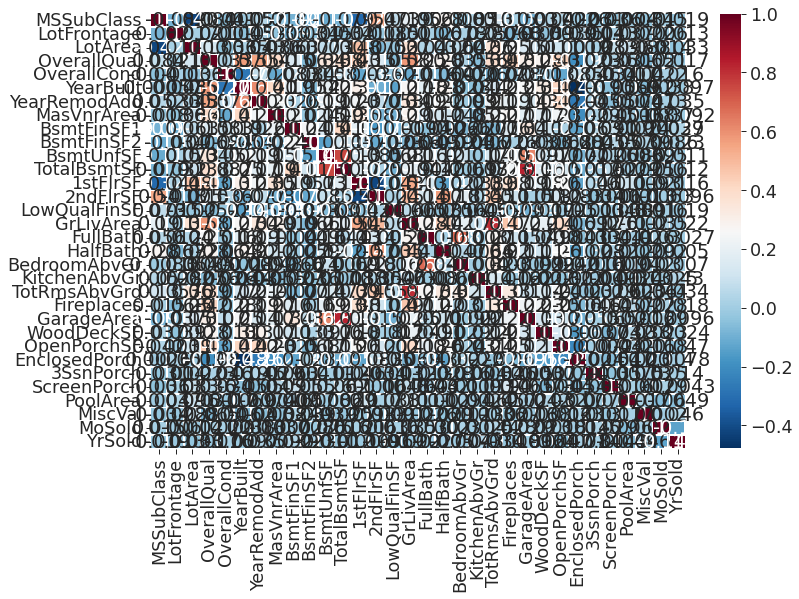

In [112]:
# heat map of correlations

houses_corr = train_test.corr()

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(houses_corr, 
            xticklabels=houses_corr.columns,
            yticklabels=houses_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

From the above, we may conclude that GrLivArea, TotRmsAbvGrd and OverallQual demonstrate high (> 50%) levels of correlations with many other columns. It is unsuprising because these features are commonly known to be best predictors of house prices. We might consider dropping them later if it allows us to improve predictive powers of our models.

In [113]:
# create dummies from categorical variables 

train_test_copy = train_test

train_test_copy = pd.get_dummies(train_test_copy, columns = categorical_houses)

# examine the dtypes 

train_test_int = train_test_copy.select_dtypes(include=['int64']).columns
train_test_float = train_test_copy.select_dtypes(include=['float64']).columns
train_test_object = train_test_copy.select_dtypes(include=['object']).columns

In [114]:
train_test_copy[['GarageArea']] = train_test_copy[['GarageArea']].astype(float)

In [115]:
# separate the original test and the train

train_1 = train_test_copy[train_test_copy['Id'] < 1461]
test_1 = train_test_copy[train_test_copy['Id'] > 1460]

KeyError: ignored

In [ ]:
# split train into validation and train

X_tr = train_1.drop(columns = ['SalePrice', 'Id'])
y_tr = train_1['SalePrice']

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=3)

# create a test set

X_test = test_1.drop(columns = ['SalePrice', 'Id'])
y_test = test_1['SalePrice']

In [ ]:
# fit scaler to X_train, transform X_train, X_val and X_test

from sklearn.preprocessing import StandardScaler

my_ss = StandardScaler()
my_ss.fit(X_train)

X_train = my_ss.transform(X_train)
X_val = my_ss.transform(X_val)
X_test = my_ss.transform(X_test)


In [ ]:
# fit PCA object to scaled X_train, transform scaled X_train and X_test

# Instantiate & fit PCA model to the breast cancer data
# Default n_components will generate the same number of PCs as you have features 

from sklearn.decomposition import PCA

my_pca = PCA()
my_pca.fit(X_train)

# transform data 
X_train_PCA = my_pca.transform(X_train)
X_val_PCA = my_pca.transform(X_val)
X_test_PCA = my_pca.transform(X_test)


In [ ]:
# explained variance ration

expl_var = my_pca.explained_variance_ratio_

# cumulative 

cumulative_sum = np.cumsum(expl_var)

# plot the the cumulative sum graph

plt.figure(figsize=(12,4))
plt.plot(range(len(cumulative_sum)), cumulative_sum, marker = '.')
plt.axhline(0.99, c='r', linestyle='--')
plt.xlabel('Number of PCs')
plt.ylabel('Cumulative Sum of Explained Variance')
plt.title('Increase in Explained Variance due to the Number of PCs')
plt.xticks()
plt.show()

We will select 500 components that explain ~99% of variance.

In [ ]:
# rerun the PC model based on 500 component

from sklearn.decomposition import PCA

my_pca = PCA(n_components=500)
my_pca.fit(X_train)

# transform data 
X_train_PCA = my_pca.transform(X_train)
X_val_PCA = my_pca.transform(X_val)
X_test_PCA = my_pca.transform(X_test)

In [ ]:
# run a linear regression

# Let's use all the default parameters for now
my_logreg = LogisticRegression(max_iter=1000, C=0.0001)

# Fitting to original data
my_logreg.fit(X_train,y_train)

from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

# generate predictions on train and validation sets validation score 

y_pred_val = my_logreg.predict(X_val)
y_pred_train = my_logreg.predict(X_train)

# Scoring on original train and test sets

print(f'RMSE in Validation Score: {mean_squared_error(y_val, y_pred_val, squared=False)}')
print(f'RMSE in Train Score: {mean_squared_error(y_train, y_pred_train, squared=False)}')
print(f'RMSLE in Validation Score: {mean_squared_log_error(y_val, y_pred_val, squared=False)}')
print(f'RMSLE in Train Score: {mean_squared_log_error(y_train, y_pred_train, squared=False)}')
print(f'R2 in Validation Score: {r2_score(y_val, y_pred_val)}')
print(f'R2 in Train Score: {r2_score(y_train, y_pred_train)}')


# Do the same but fit on the PCA transformed data
my_logreg_PCA = LogisticRegression(max_iter=1000, C=0.0001)

# Fitting to PCA data
my_logreg_PCA.fit(X_train_PCA,y_train)

# generate predictions on train and validation sets validation score using PCA-data

y_pred_val_PCA = my_logreg_PCA.predict(X_val_PCA)
y_pred_train_PCA = my_logreg_PCA.predict(X_train_PCA)

# Scoring on PCA train and test sets

print(f'RMSE in Validation Score: {mean_squared_error(y_val, y_pred_val_PCA, squared=False)}')
print(f'RMSE in Train Score: {mean_squared_error(y_train, y_pred_train_PCA, squared=False)}')
print(f'RMSLE in Validation Score: {mean_squared_log_error(y_val, y_pred_val_PCA, squared=False)}')
print(f'RMSLE in Train Score: {mean_squared_log_error(y_train, y_pred_train_PCA, squared=False)}')
print(f'R2 in Validation Score: {r2_score(y_val, y_pred_val_PCA)}')
print(f'R2 in Train Score: {r2_score(y_train, y_pred_train_PCA)}')


In [ ]:
y_train.mean()

In [ ]:
# run a linear regression 

from scipy import stats
import statsmodels.api as sm

X_withconstant = sm.add_constant(X_train)

# 1. Instantiate Model
myregression = sm.OLS(y_train, X_withconstant)

# 2. Fit Model (this returns a seperate object with the parameters)
myregression_results = myregression.fit()

# Looking at the summary
myregression_results.summary()
